In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv
/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv


KeyboardInterrupt: 

In [8]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install --upgrade tensorflow-gpu

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from tensorflow import keras 

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16


dataset = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [7]:
# Groupby subjects
by_drivers = dataset.groupby('subject') 
# Groupby unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id
print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(dataset.groupby('subject').count()['classname'].mean()), ' images by driver.')

There are :  26  unique drivers
There is a mean of  862  images by driver.


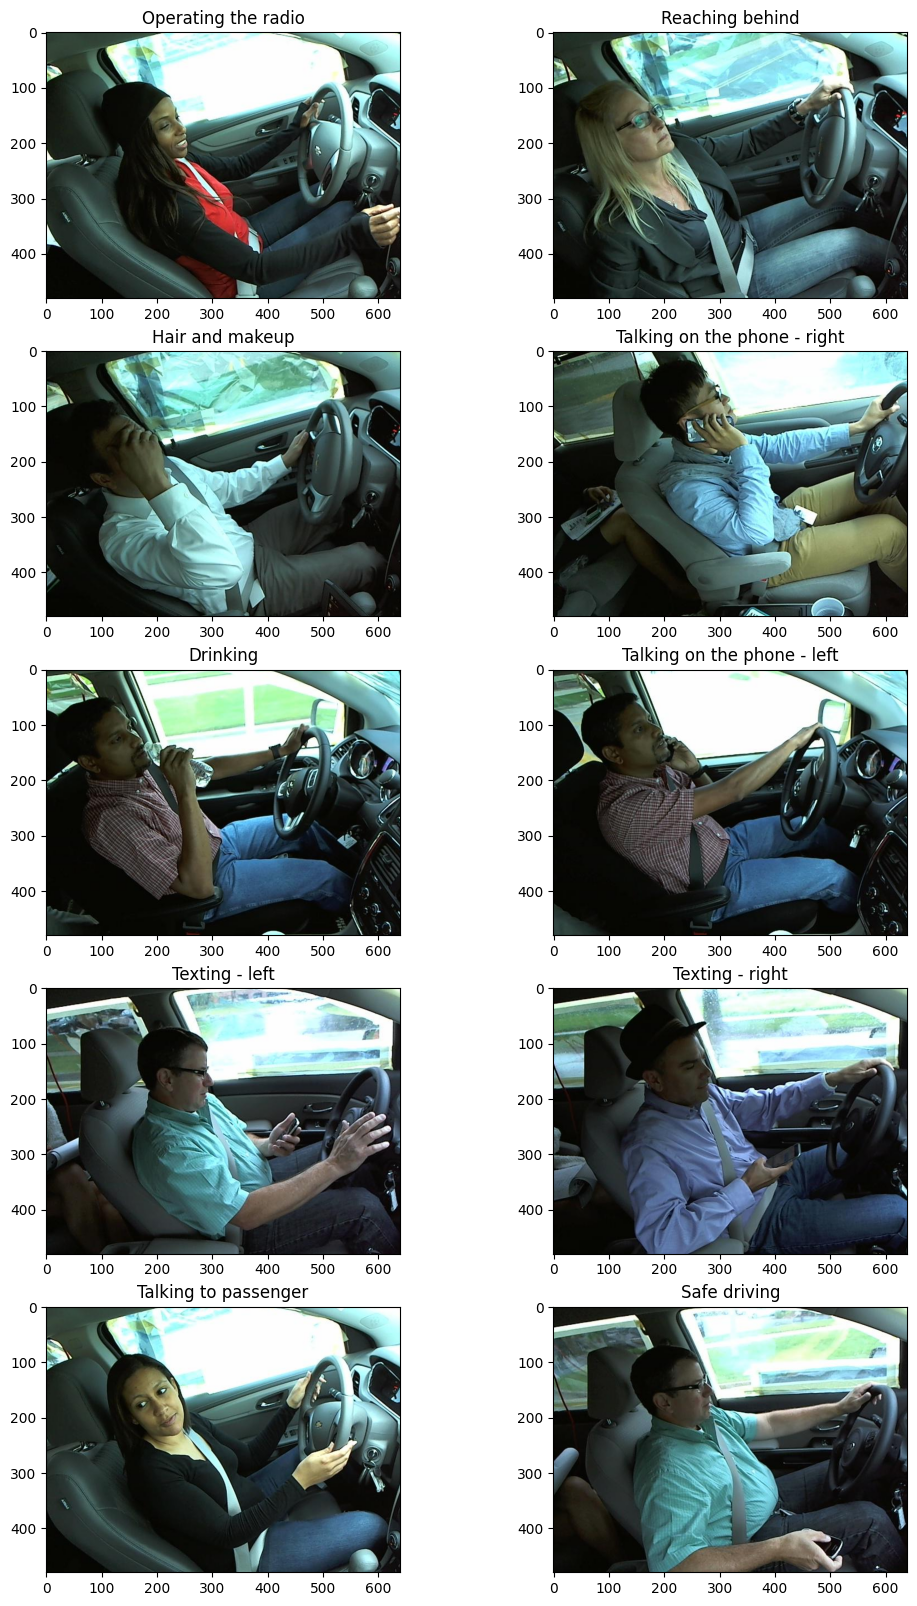

In [17]:
NUMBER_CLASSES = 10 # 10 classeslinkcode
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '../input/state-farm-distracted-driver-detection/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

이미지제너레이터를 이용한 데이터셋 생성

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
  Conv2D(96,(11,11), strides=4, activation='relu', input_shape=(227,227,3)), 
  MaxPooling2D(pool_size=(3,3), strides=2),

  Conv2D(256,(5,5), strides=1, activation='relu'), 
  MaxPooling2D(pool_size=(3,3), strides=2),

  Conv2D(384,(3,3), padding='same', activation='relu'), 
  Conv2D(384,(3,3), padding='same', activation='relu'), 
  Conv2D(256,(3,3), padding='same', activation='relu'), 

  Flatten(),
    
  Dense(1024, activation='relu'),
  Dropout(0.5),

  Dense(NUMBER_CLASSES, activation='softmax')
]
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 23, 23, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 11, 11, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 11, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 11, 11, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    31,720,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,477,898 (135.34 MB)

 Trainable params: 35,477,898 (135.34 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=validation_generator.samples // 32
)

Epoch 1/10


I0000 00:00:1731432923.392802      93 service.cc:145] XLA service 0x7a9c000027d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731432923.392865      93 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731432923.392869      93 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/560 ━━━━━━━━━━━━━━━━━━━━ 1:36:10 10s/step - accuracy: 0.0312 - loss: 2.3057

I0000 00:00:1731432929.670382      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


560/560 ━━━━━━━━━━━━━━━━━━━━ 167s 280ms/step - accuracy: 0.4168 - loss: 1.5973 - val_accuracy: 0.9009 - val_loss: 0.3109
Epoch 2/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.2867 - val_accuracy: 0.0000e+00 - val_loss: 3.5712
Epoch 3/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 66s 116ms/step - accuracy: 0.9350 - loss: 0.2182 - val_accuracy: 0.9565 - val_loss: 0.1397
Epoch 4/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 1.0000 - loss: 0.0208 - val_accuracy: 1.0000 - val_loss: 1.2875e-05
Epoch 5/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 66s 116ms/step - accuracy: 0.9659 - loss: 0.1108 - val_accuracy: 0.9763 - val_loss: 0.0885
Epoch 6/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 29us/step - accuracy: 0.9688 - loss: 0.1273 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 66s 117ms/step - accuracy: 0.9842 - loss: 0.0559 - val_accuracy: 0.9837 - val_loss: 0.0698
Epoch 8/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 32us/step - accuracy: 1.0000 - loss: 0.0147 -

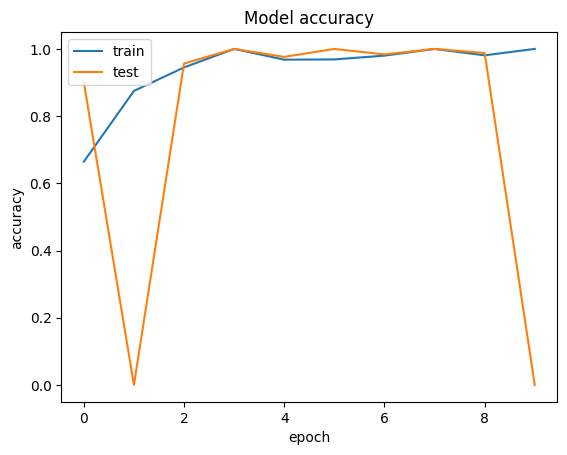

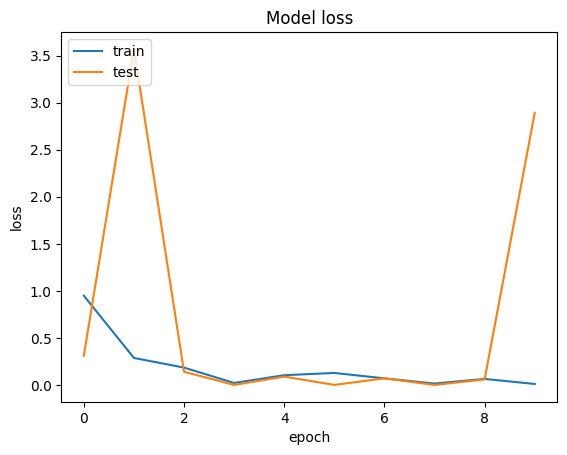

In [20]:
def plot_train_history(history):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_train_history(history)